# Import Library

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

from IPython.display import clear_output

# Classes and Function

In [11]:
class Point: 
    def __init__(self, id, x, y, partition):
        self.id = id
        self.partition = partition
        self.x = x
        self.y = y 

    def get_pos(self):
        return self.x, self.y

In [12]:
class Graph: 
    def __init__(self, points = {}, weight = np.array([[]])): 
        self.points = points
        self.weight = weight
        self.all_weight = weight

    def get_points(self):
        return self.points        
        
    def get_points_coords(self): 
        points_x = np.array([])
        points_y = np.array([])

        for i in self.points:
            points_x = np.append(points_x, self.points[i].get('x'))
            points_y = np.append(points_y, self.points[i].get('y'))

        return points_x, points_y

    def get_weight(self):
        return self.weight

    def get_spread(self):
        points_x, points_y = self.get_points_coords()
        return max(max(points_x) - min(points_y), max(points_y) - min(points_y))

    def is_connected(self):
        if(self.weight.size == 0): 
            return False
            
        num_vertices = len(self.points)

        def dfs(vertex, visited):
            visited[vertex] = True
            for neighbor in range(num_vertices):
                if self.weight[vertex, neighbor] != 0 and not visited[neighbor]:
                    dfs(neighbor, visited)

        visited = [False] * num_vertices

        dfs(0, visited)

        return all(visited)

    def calculate_weight(self, min_s, max_s):
        iteration = 0
        points_x, points_y = self.get_points_coords()
        size = len(points_x)
        temp = np.zeros([size, size])
        for i in range(size):
            for j in range(size):
                temp[i, j] = np.sqrt(np.abs(points_x[i] - points_x[j]) ** 2 + np.abs(points_y[i] - points_y[j]) ** 2)
        
        self.all_weight = np.copy(temp)
        self.weight = np.zeros([size, size])
        while(not self.is_connected()):
            iteration += 1
            if(min_s != 0 and max_s != 0):
                new_weight = np.zeros([size, size])
                
                for j in range(size):
                    n_edge_rand = np.random.randint(min_s, max_s)
                    idx = np.argpartition(self.all_weight[j, :], n_edge_rand)
                    for k in idx[1:n_edge_rand + 1]:
                        new_weight[j, k] = self.all_weight[j, k]
                    new_weight[:, j] = new_weight[j, :]
                    
            self.weight = np.copy(new_weight)

            if(iteration % 100 == 0):
                if(min_s < max_s - 1):
                    min_s += 1
                else:
                    max_s += 1
                    
        print('Iterations: ', iteration, 'Min Side:', min_s, 'Max Side:', max_s)
        return self.weight

    def update_partition(self, id, partition):
        self.points[id]['partition'] = partition

    def add_point(self, point): 
        self.points[point.id] = {'x': point.x, 'y': point.y, 'partition': point.partition}

    def remove_point(self, id):
        try:
            self.points.pop(id)
        except:
            print('point not in partition')

In [13]:
def generate_rand_points(graph, n, interval): 
    temp = np.random.rand(2, n) * interval[0] + interval[1]
    for i in range(n):
        graph.add_point(Point(i, temp[0, i], temp[1, i], -1))
    return graph

## Generate Graph

In [25]:
n_points = 100
n_partition = 5
interval = [-10, 10]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

Iterations:  1 Min Side: 3 Max Side: 4


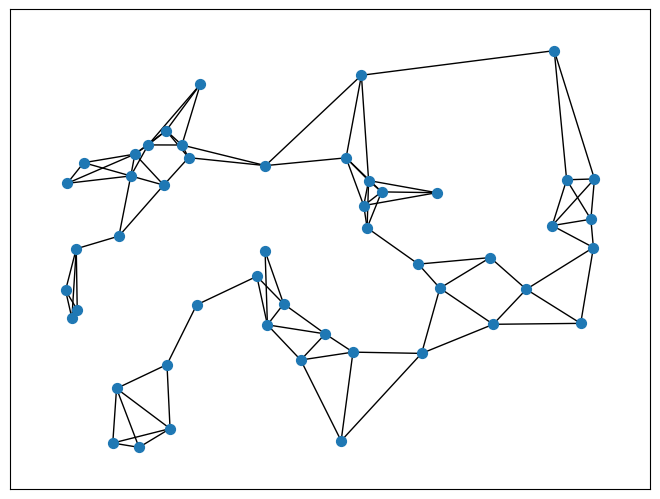

In [65]:
weight = graph.calculate_weight(3, 4)
pos = {i: (graph.get_points()[i].get("x"),  graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

In [73]:
def random_connected_partitions(graph, adjacency_matrix, num_partitions):
    G = nx.Graph(np.array(adjacency_matrix))
    G_full = nx.Graph(np.array(adjacency_matrix))

    def bfs_limit(graph, source, min_size):
        visited = set()
        queue = [source]

        while queue and len(visited) < min_size:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                queue.extend(neighbor for neighbor in graph.neighbors(node) if neighbor not in visited)

        return visited
        
    nodes = list(G.nodes())

    partition_size = len(nodes) // num_partitions
    partitions = []
    current_degree = 1

    for i in range(num_partitions):
        degree = {}
        for j in G.nodes():
            temp = degree.get(G.degree(j), np.array([]))
            temp = np.append(temp, int(j))
            np.random.shuffle(temp)
            degree[G.degree(j)] = temp
            
        while True:
            if(len(degree.get(current_degree, [])) == 0):
                current_degree += 1
            else: 
                temp = degree.get(current_degree)
                np.random.shuffle(temp)

                start_node = degree.get(current_degree)[0]
                break

        partition = list(bfs_limit(G, start_node, partition_size))
        
        G.remove_nodes_from(partition)
        partitions.append(partition)
        # print(f"Iteration {i} done")

    for i in G.nodes():
        index, min_partitions = -1, -1
        for j, val in enumerate([n for n in G_full.neighbors(i)]):
            for k, val_p in enumerate(partitions): 
                if(val in val_p and min_partitions == -1):
                    index = k
                    min_partition = len(val_p)
                elif(val in val_p and len(val_p) < min_partition):
                    index = k
                    min_partition = len(val_p)

        partitions[index].append(i)
    
    partition_vector = np.zeros(len(nodes), dtype=int)
    for i, partition in enumerate(partitions):
        partition_vector[[int(j) for j in partition]] = i + 1 

    for i, val in enumerate(partition_vector):
        graph.update_partition(i, val)

    return partition_vector

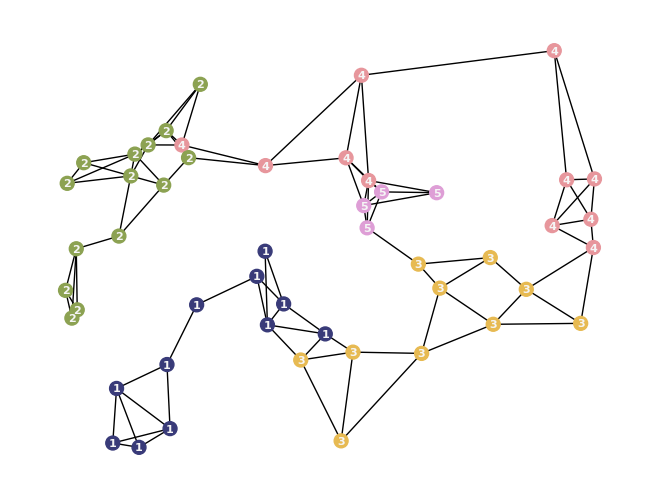

In [140]:
partition_result = random_connected_partitions(graph, weight, n_partition)

node_colors = [partition_result[node] for node in G.nodes()]
labels = {node: f'{partition_result[node]}' for node in G.nodes()}
label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  # Adjust the y-position

nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='whitesmoke', font_weight='800')

plt.show()

# Optimization 

## Selection 

In [107]:
n_population = 6
populations = np.array([])
partition_results = np.array([])

for i in range(n_population):
    new_graph = deepcopy(graph) 
    partition_result = random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)
    partition_results = np.append(partition_results, partition_result)

partition_results = partition_results.reshape(n_population, n_points)

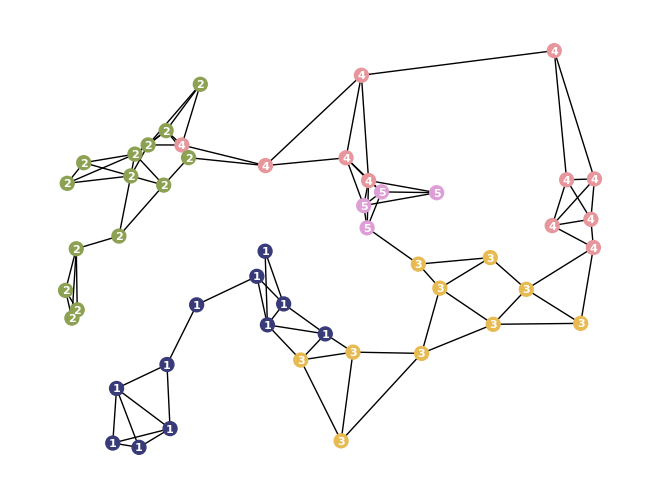

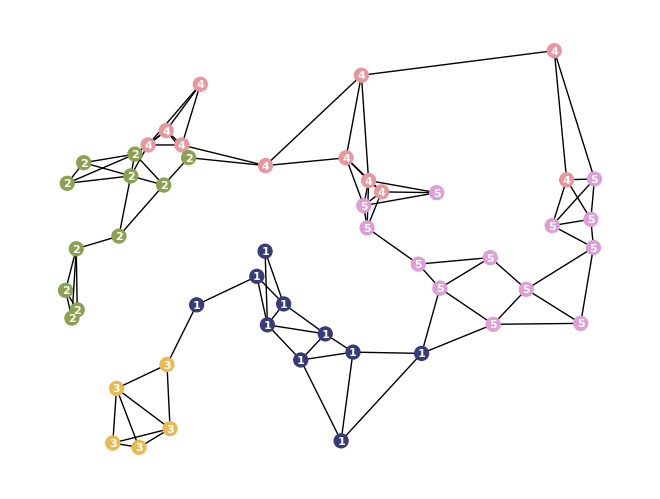

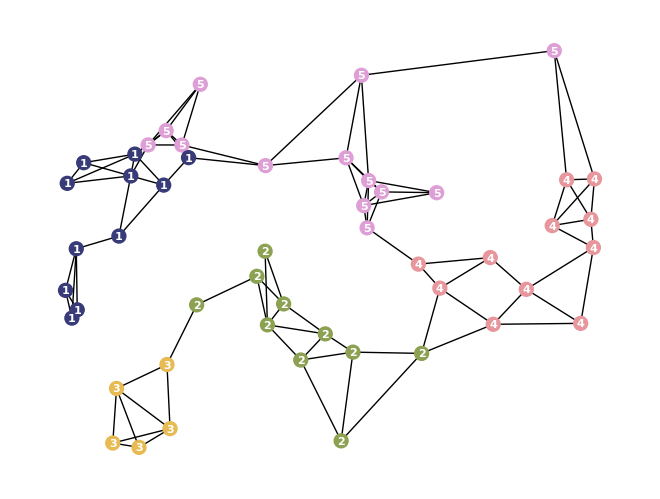

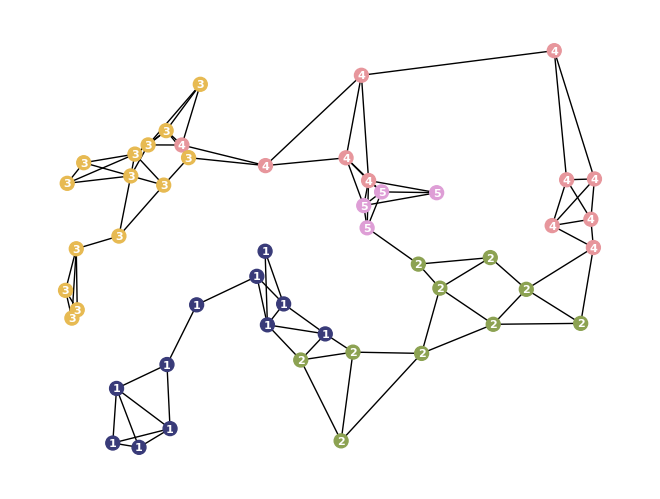

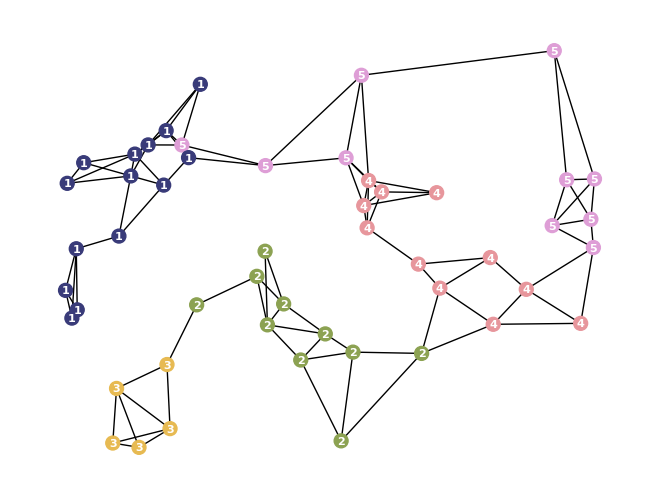

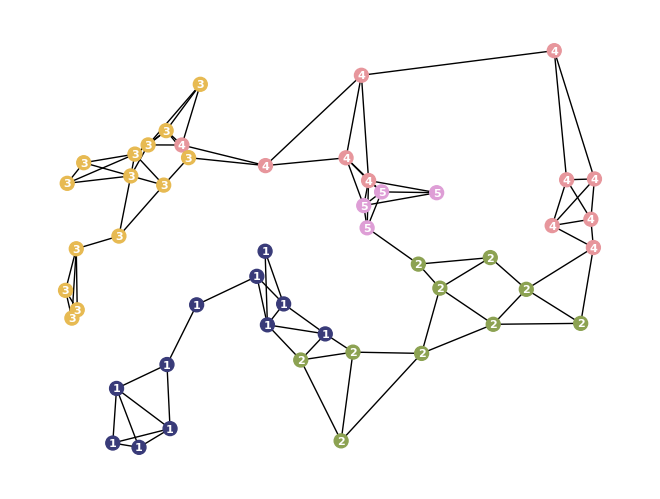

In [139]:
for partition_result in partition_results:
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{int(partition_result[node])}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  # Adjust the y-position

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()